# Задачи бинарной классификации

**Борисочкин Михаил ML-12**

## Задание

В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:
- Date - Дата наблюдений
- Location - Название локации, в которой расположена метеорологическая станция
- MinTemp - Минимальная температура в градусах цельсия
- MaxTemp - Максимальная температура в градусах цельсия
- Rainfall - Количество осадков, зафиксированных за день в мм
- Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
- Sunshine - Число солнечных часов за день
- WindGustDir - направление самого сильного порыва ветра за последние 24 часа
- WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
- WindDir9am - направление ветра в 9 утра
- WindDir3pm - направление ветра в 3 дня
- Pressure9am - давление в 9 утра
- Pressure3pm - давление в 3 дня
- Cloud9am - облачность в 9 утра
- Cloud3pm - облачность в 3 дня
- Temp9am - температура в 9 утра
- Temp9pm - температура в 3 дня
- RainToday - был ли сегодня дождь
- RainTomorrow - будет ли завтра дождь. Целевой признак

In [58]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Разведочный анализ данных

In [2]:
# Загрузка исходного набора данных
data = pd.read_csv("weather.csv", index_col=0)
data.sample(10, random_state=42)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
57760,2016-06-09,Ballarat,7.1,13.0,8.8,NaN,NaN,N,41.0,N,...,100.0,98.0,1001.7,1005.4,8.0,8.0,8.6,11.5,Yes,Yes
127128,2009-10-24,Walpole,13.2,18.3,0.0,NaN,NaN,E,48.0,ESE,...,73.0,73.0,1027.6,1023.8,NaN,NaN,14.2,17.0,No,No
119994,2015-09-21,PerthAirport,9.2,22.7,0.0,5.0,11.1,ENE,52.0,ENE,...,45.0,25.0,1030.1,1025.9,0.0,0.0,15.1,22.5,No,No
7088,2011-12-06,Cobar,15.3,26.1,0.0,10.4,NaN,E,44.0,E,...,48.0,40.0,1013.2,1009.8,7.0,7.0,17.5,24.3,No,No
62992,2014-03-15,Sale,11.9,31.8,0.0,5.0,4.1,NW,72.0,E,...,89.0,25.0,1006.7,1001.0,7.0,6.0,16.2,27.4,No,Yes
28722,2013-07-03,Richmond,2.4,19.0,0.0,1.0,NaN,NE,17.0,NaN,...,100.0,56.0,1024.9,1020.5,NaN,NaN,5.8,18.8,No,No
134837,2014-02-08,Launceston,15.6,32.7,0.0,NaN,NaN,WNW,31.0,NNE,...,78.0,33.0,1014.2,1011.7,NaN,NaN,20.3,32.0,No,No
57446,2015-07-31,Ballarat,-1.1,9.0,2.8,NaN,NaN,N,61.0,NNE,...,100.0,55.0,1021.7,1017.1,1.0,NaN,2.5,8.6,Yes,Yes
70481,2009-03-30,Mildura,11.9,31.8,0.0,8.0,11.0,E,30.0,SSE,...,36.0,10.0,1021.9,1019.2,1.0,1.0,15.4,30.9,No,No
14244,2015-03-17,Moree,19.1,32.6,0.0,9.2,9.5,NNE,61.0,NNE,...,56.0,34.0,1014.3,1009.7,1.0,4.0,22.2,30.7,No,Yes


In [3]:
# Информация об исходном наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

In [4]:
# Количество пропущенных значений для каждого признака (в процентах)
data.isnull().sum() / data.shape[0] * 100

Date              0.000000
Location          0.000000
MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
RainToday         0.988797
RainTomorrow      0.000000
dtype: float64

В признаках Evaporation, Sunshine, Cloud9am, Cloud3pm пропущено около половины значений, что не очень хорошо.

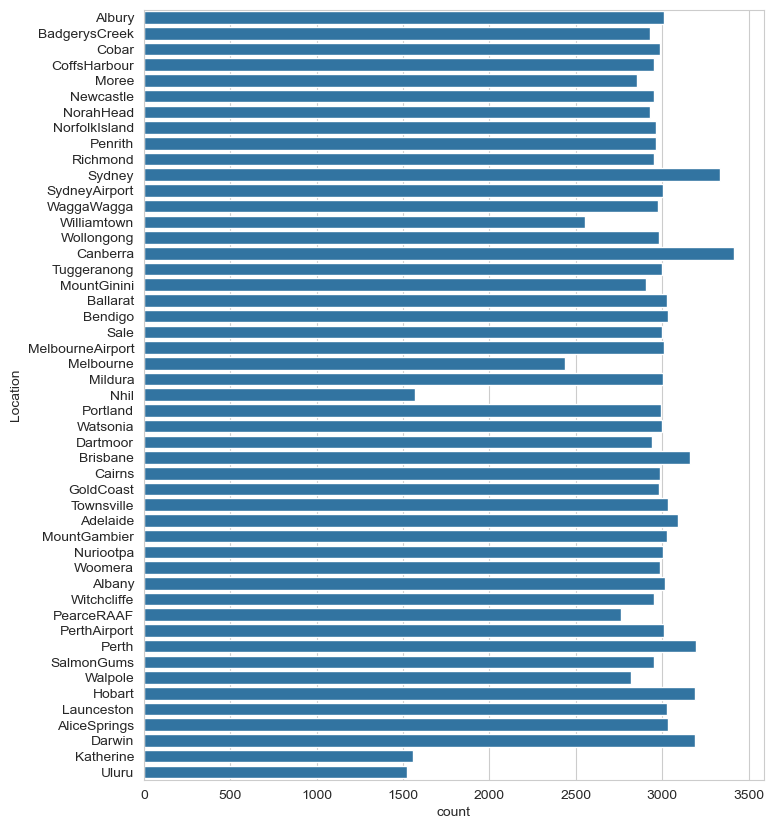

In [5]:
# Распределение локаций
_, ax = plt.subplots(figsize=(8, 10))
sns.countplot(y="Location", data=data, ax=ax)
plt.show()

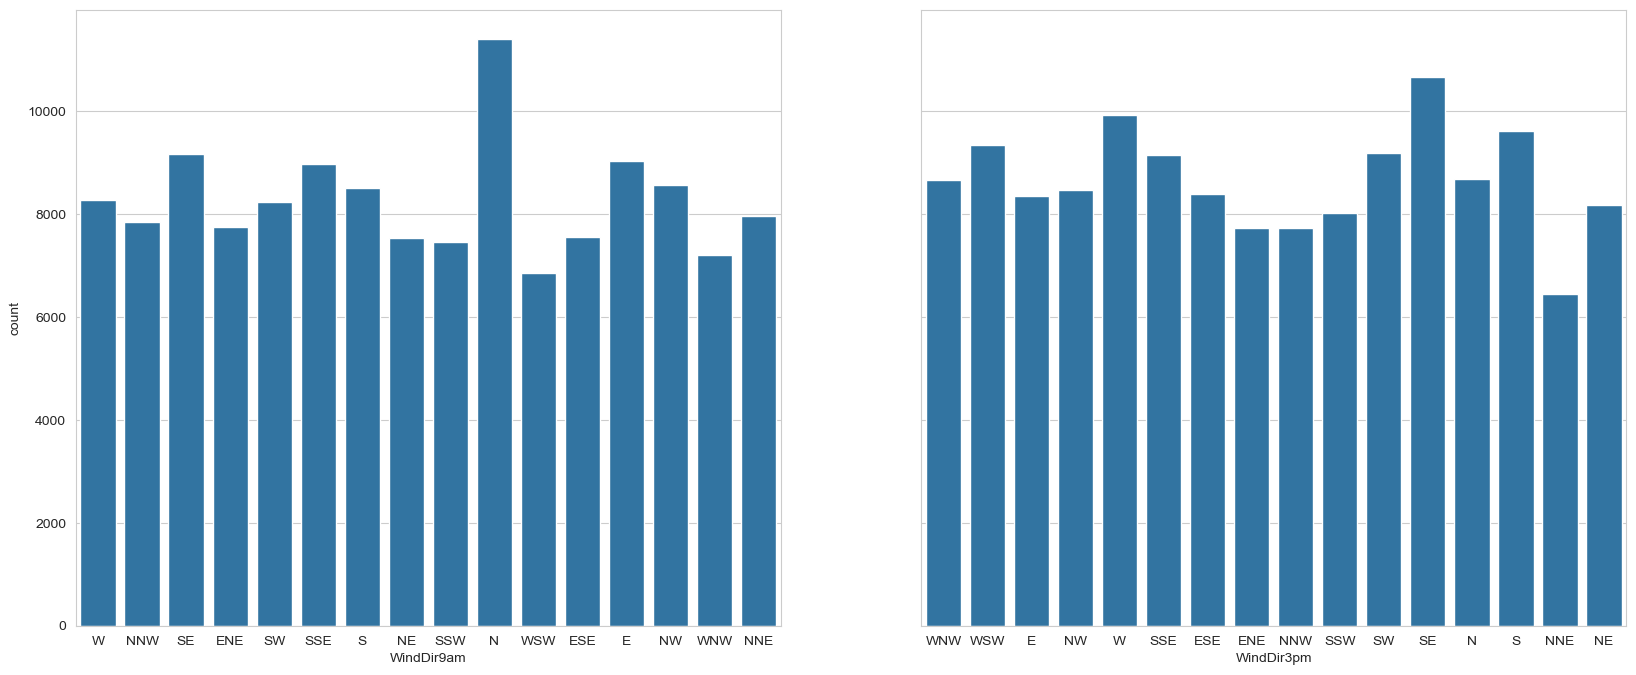

In [6]:
# Распределения направлений ветра в 9 утра и 3 дня
_, ax = plt.subplots(ncols=2, figsize=(20, 8), sharey=True)
sns.countplot(x="WindDir9am", data=data, ax=ax[0])
sns.countplot(x="WindDir3pm", data=data, ax=ax[1])
plt.show()

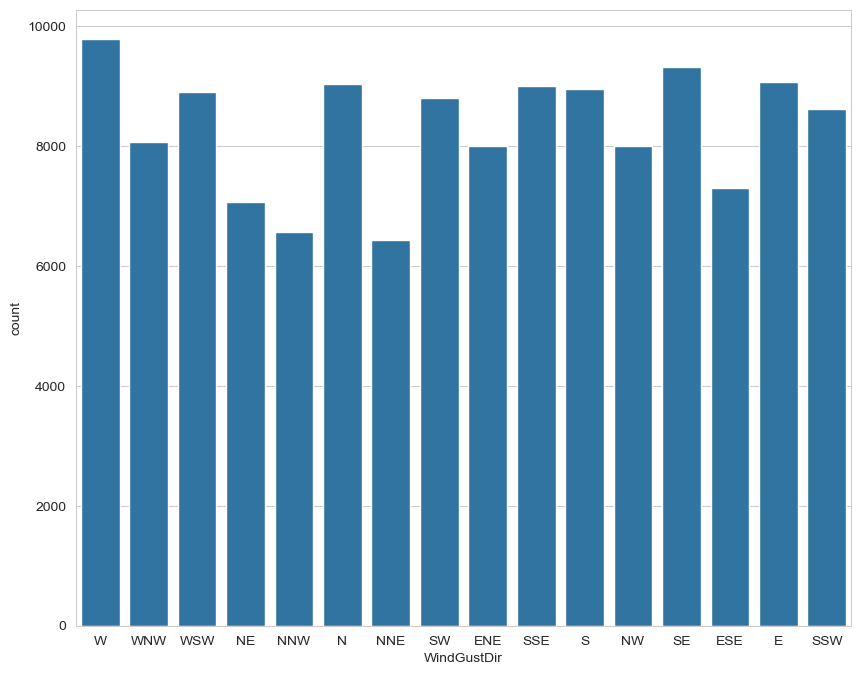

In [7]:
# Распределение направления сильного ветра
_, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x="WindGustDir", data=data, ax=ax)
plt.show()

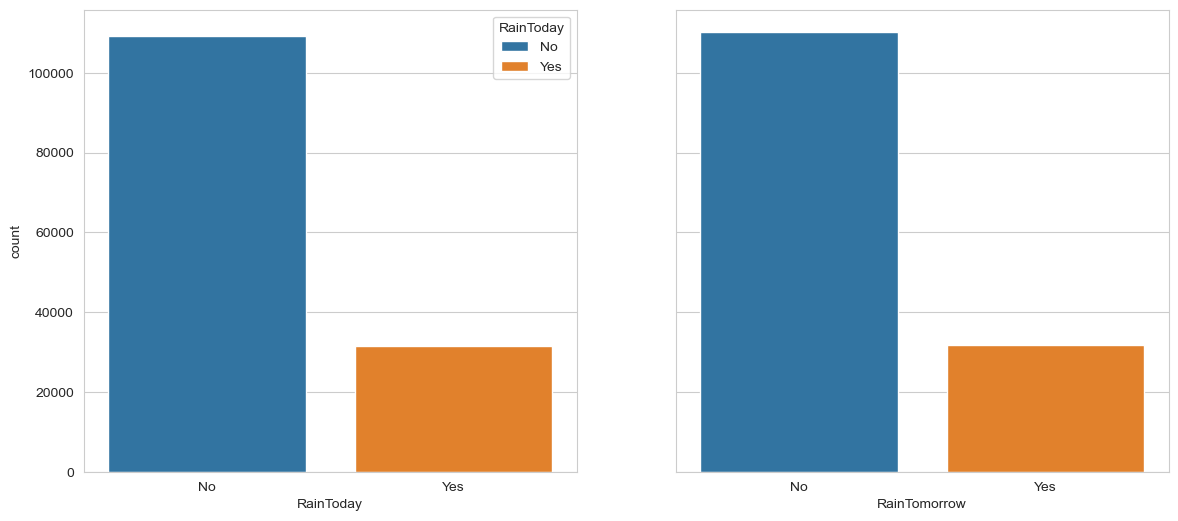

In [8]:
# Распределения признаков наличия дождя сегодня и завтра
_, ax = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)
sns.countplot(x="RainToday", data=data, ax=ax[0], hue="RainToday")
sns.countplot(x="RainTomorrow", data=data, ax=ax[1], hue="RainTomorrow")
plt.show()

Как видно из распределений выше классы несбалансированы

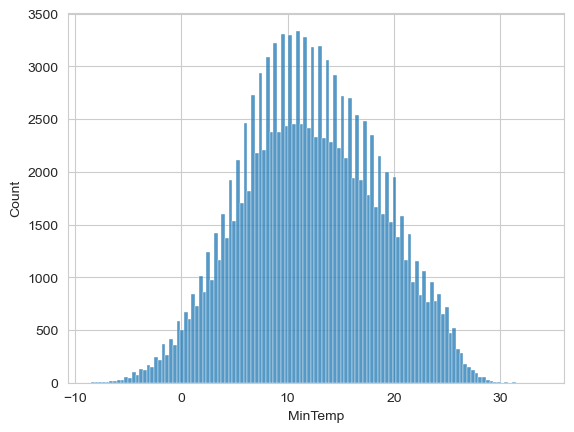

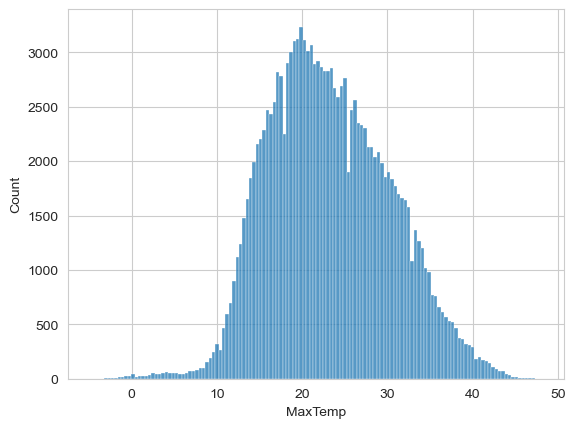

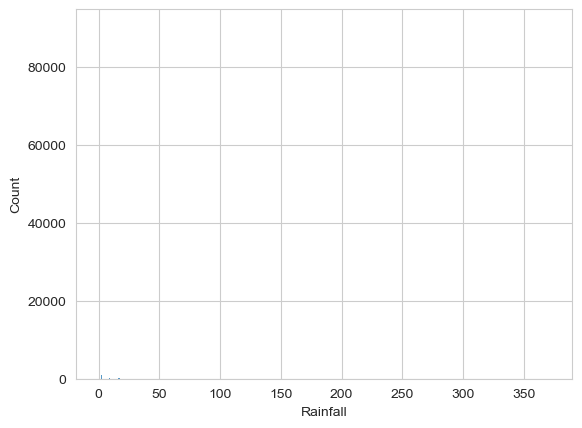

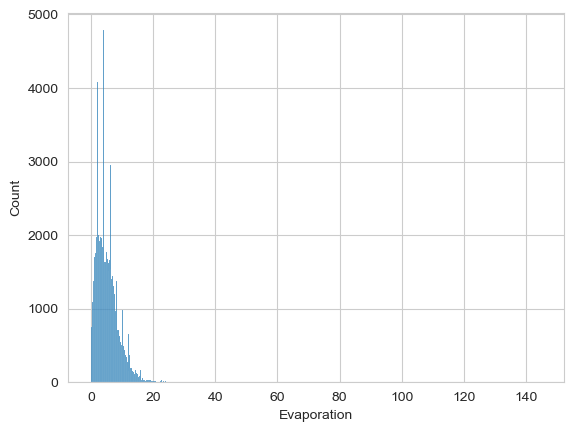

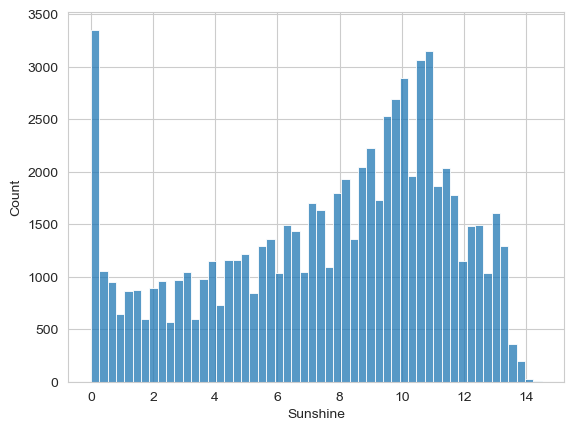

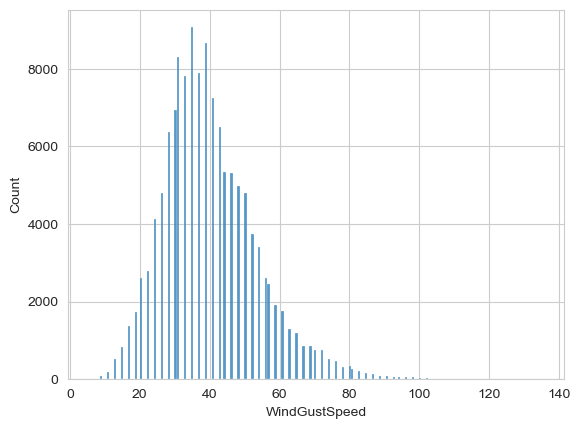

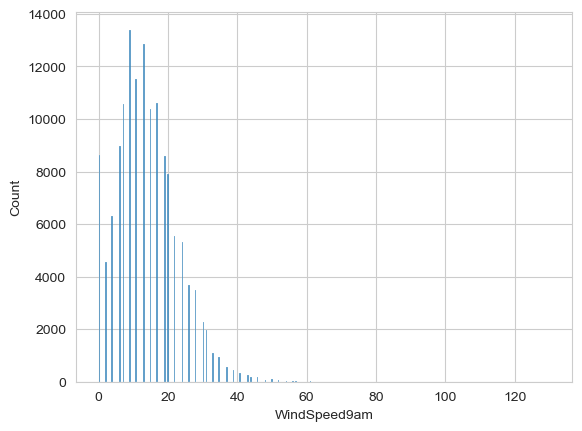

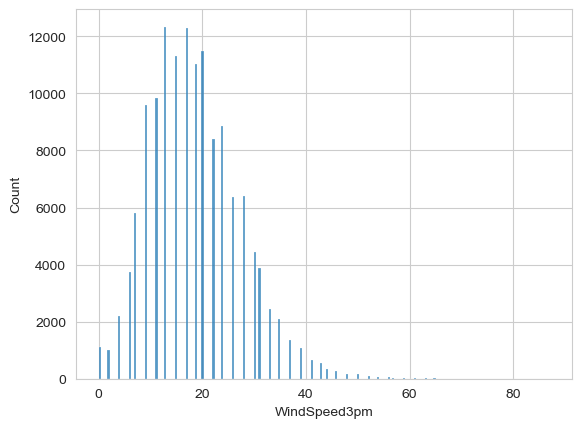

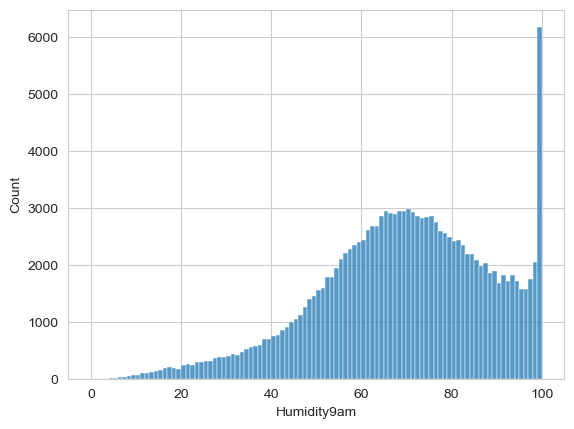

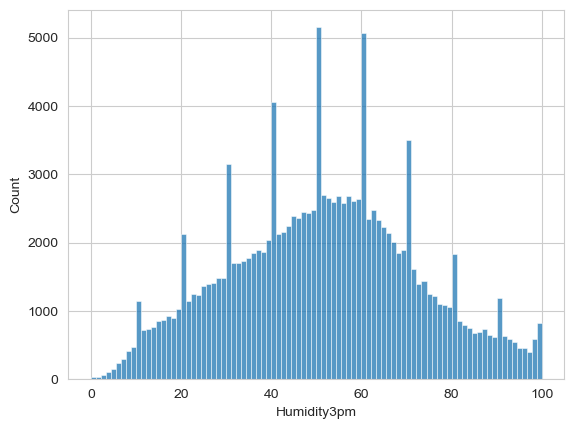

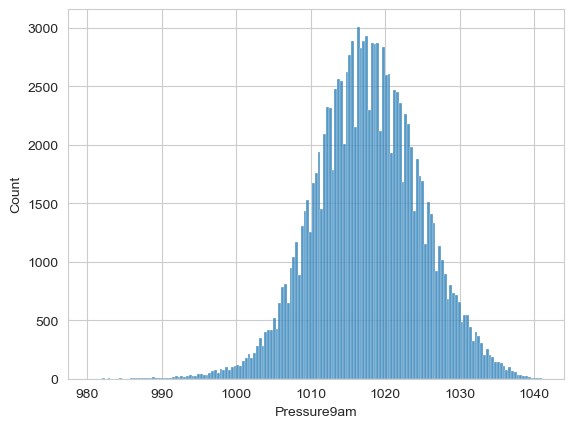

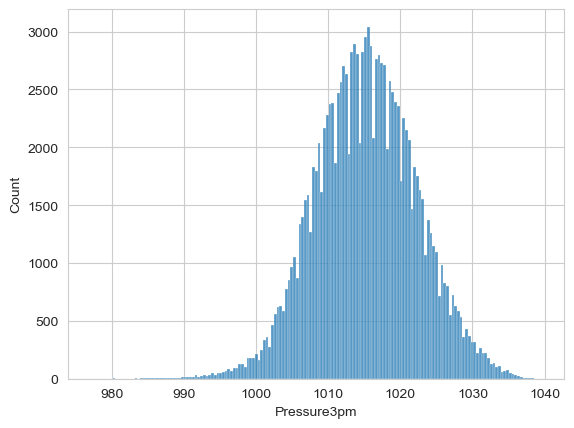

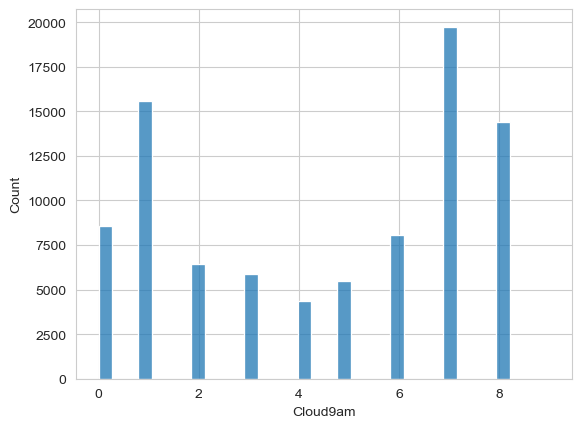

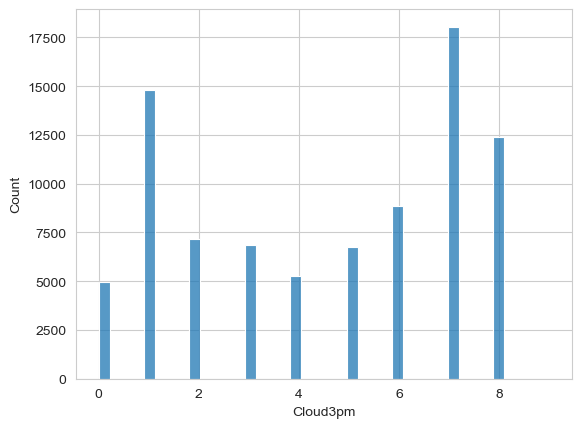

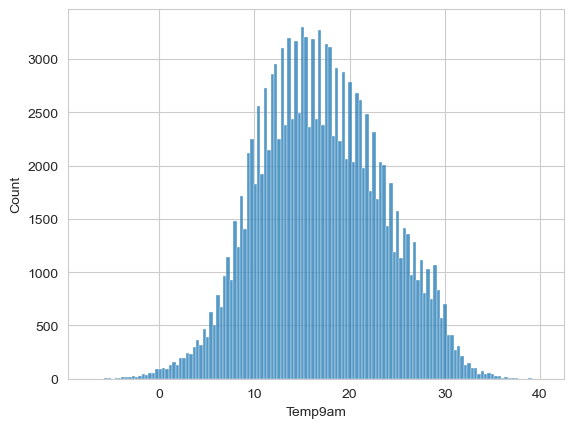

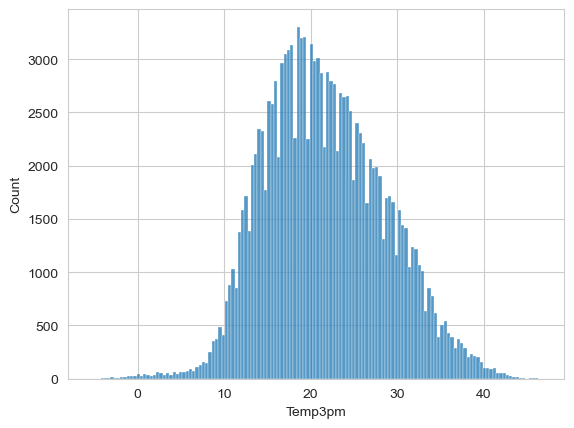

In [9]:
# Распределение числовых признаков
data_numeric = data.select_dtypes(include=[np.number])
for col in data_numeric.columns:
    sns.histplot(data, x=col)
    plt.show()

Распределение большинства числовых признаков близко к нормальному.

### Корреляционный анализ

Для корреляционного анализа разделим дату на составные части: год, месяц, день, а также закодируем признаки RainToday и RainTomorrow

In [10]:
# Разделение даты на год, месяц и день
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day

data = data.drop(columns=["Date"])

# Перемещение колонок
year = data.pop("Year")
data.insert(0, "Year", year)
month = data.pop("Month")
data.insert(1, "Month", month)
day = data.pop("Day")
data.insert(2, "Day", day)

In [11]:
# Кодирование "дождевых признаков"
data["RainToday"] = data["RainToday"].map({"No": 0, "Yes": 1})
data["RainTomorrow"] = data["RainTomorrow"].map({"No": 0, "Yes": 1})

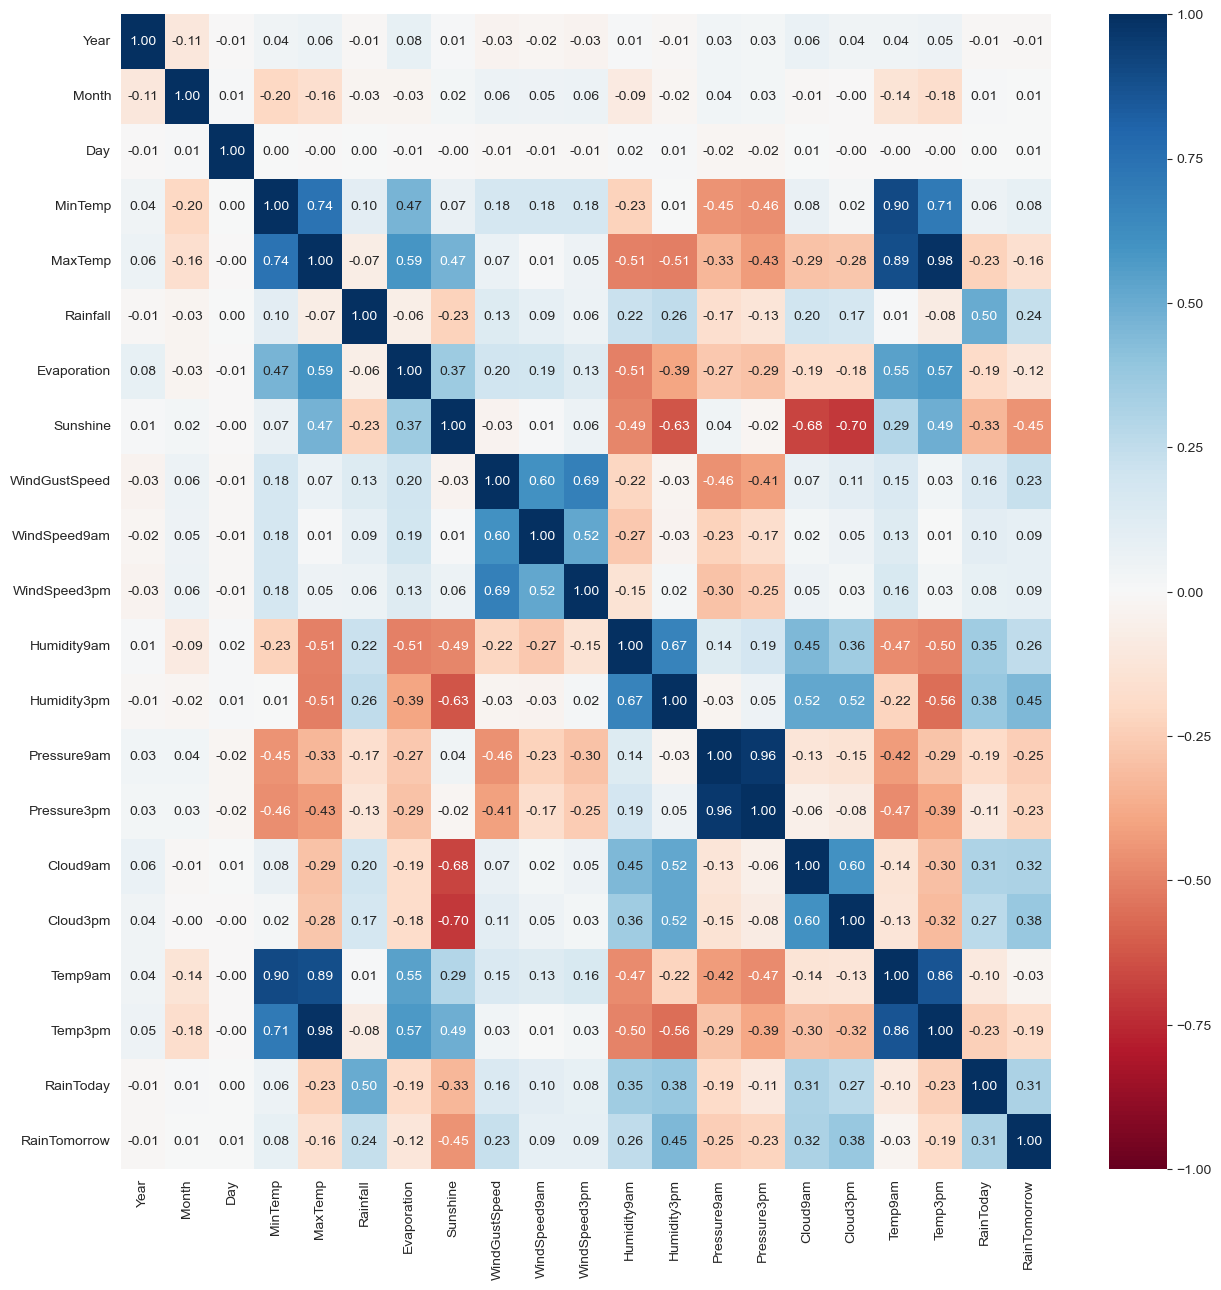

In [12]:
# Тепловая карта корреляционной матрицы
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    data.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    ax=ax,
    fmt=".2f",
    cmap="RdBu",
)
plt.show()

Лучше всего с целевым признаком коррелирует Sunshine и Humidity3pm. Однако среди нецелевых признаков есть несколько групп признаков с сильной корреляцией, что может исказить оценку модели.

## Предобработка данных

Объединим два признака, связанных с давлением, в один. Удалим признаки, связанные с облаками, а также температурой, кроме Temp3pm, т. к. он сильнее всего коррелирует с целевым признаком среди прочих температурных признаков.

In [13]:
# Создание нового признака Pressure и удаление ненужных признаков
data_preprocessed = data.copy()
data_preprocessed["Pressure"] = (
    data_preprocessed["Pressure9am"] + data_preprocessed["Pressure3pm"]
) / 2
data_preprocessed = data_preprocessed.drop(
    columns=[
        "Pressure9am",
        "Pressure3pm",
        "Cloud3pm",
        "Cloud9am",
        "MinTemp",
        "MaxTemp",
        "Temp9am",
    ]
)

pressure = data_preprocessed.pop("Pressure")
data_preprocessed.insert(data_preprocessed.shape[1] - 2, "Pressure", pressure)

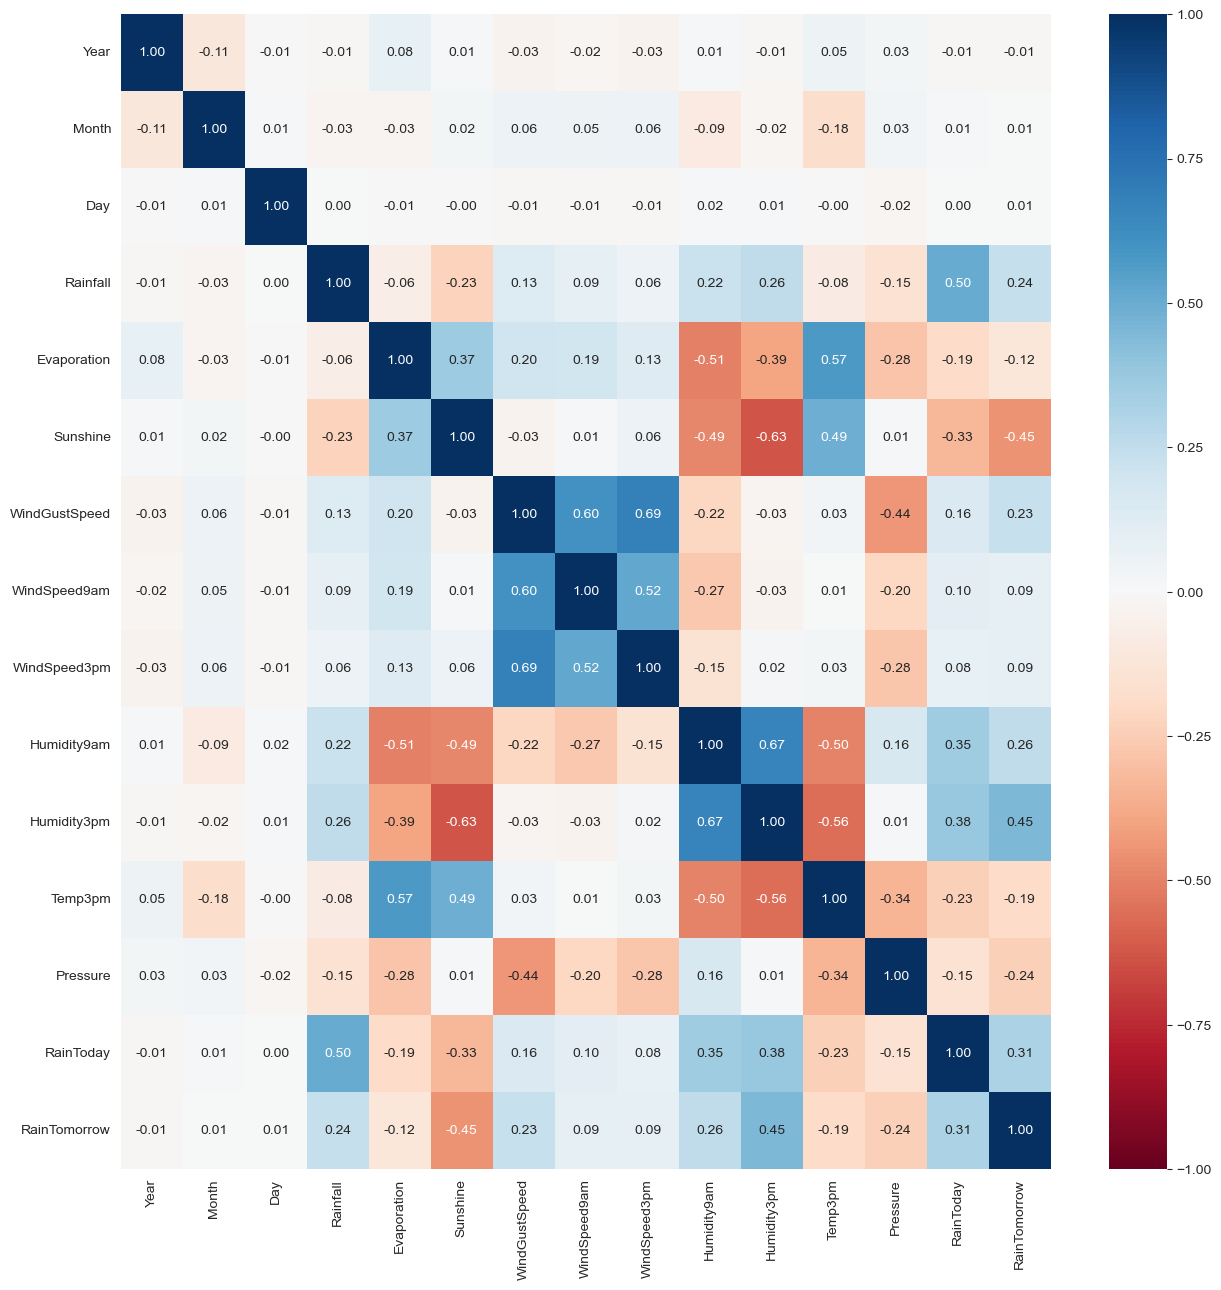

In [14]:
# Тепловая карта корреляционной матрицы
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    data_preprocessed.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    ax=ax,
    fmt=".2f",
    cmap="RdBu",
)
plt.show()

### Заполнение пропусков

In [15]:
# Количество пропусков ДО заполнения (в процентах)
data_preprocessed.isnull().sum() / data_preprocessed.shape[0] * 100

Year              0.000000
Month             0.000000
Day               0.000000
Location          0.000000
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustDir       6.561504
WindGustSpeed     6.519308
WindDir9am        7.041838
WindDir3pm        2.656952
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Temp3pm           1.917113
Pressure          9.989240
RainToday         0.988797
RainTomorrow      0.000000
dtype: float64

In [16]:
# Заполнение пропусков

# Направления ветра заполняются значением Unknown
windDirImputer = SimpleImputer(strategy="constant", fill_value="Unknown")
windDir_columns = ["WindDir9am", "WindDir3pm", "WindGustDir"]
data_preprocessed[windDir_columns] = windDirImputer.fit_transform(
    data_preprocessed[windDir_columns]
)

# Числовые значения заполняются средним значением, так как распределения близки к нормальным
meanImputer = SimpleImputer(strategy="mean")
small_null_columns = [
    "Sunshine",
    "Evaporation",
    "Rainfall",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Temp3pm",
    "Pressure",
]
data_preprocessed[small_null_columns] = meanImputer.fit_transform(
    data_preprocessed[small_null_columns]
)

# RainToday заполняется модой
rainTodayImputer = SimpleImputer(strategy="most_frequent")
data_preprocessed["RainToday"] = rainTodayImputer.fit_transform(
    data_preprocessed[["RainToday"]]
)

In [17]:
# Количество пропусков ПОСЛЕ заполнения (в процентах)
data_preprocessed.isnull().sum() / data_preprocessed.shape[0] * 100

Year             0.0
Month            0.0
Day              0.0
Location         0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Temp3pm          0.0
Pressure         0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

### Кодирование категориальных признаков

Так как уникальных значений во всех категориальных признаках достаточно много, то закодируем данные признаки числовыми значениями.

In [18]:
# Категориальные признаки ДО кодирования
cat_columns = ["Location"] + windDir_columns
data_preprocessed[cat_columns]

,Location,WindDir9am,WindDir3pm,WindGustDir
0,Albury,W,WNW,W
1,Albury,NNW,WSW,WNW
2,Albury,W,WSW,WSW
3,Albury,SE,E,NE
4,Albury,ENE,NW,W
...,...,...,...,...
145454,Uluru,ESE,E,E
145455,Uluru,SE,ENE,E
145456,Uluru,SE,N,NNW
145457,Uluru,SE,WNW,N


In [19]:
# Кодирование категориальных признаков
encoder = OrdinalEncoder()
data_preprocessed[cat_columns] = encoder.fit_transform(data_preprocessed[cat_columns])

In [20]:
# Категориальные признаки ПОСЛЕ кодирования
data_preprocessed[cat_columns]

,Location,WindDir9am,WindDir3pm,WindGustDir
0,2.0,14.0,15.0,14.0
1,2.0,6.0,16.0,15.0
2,2.0,14.0,16.0,16.0
3,2.0,9.0,0.0,4.0
4,2.0,1.0,7.0,14.0
...,...,...,...,...
145454,41.0,2.0,0.0,0.0
145455,41.0,9.0,1.0,0.0
145456,41.0,9.0,3.0,6.0
145457,41.0,9.0,15.0,3.0


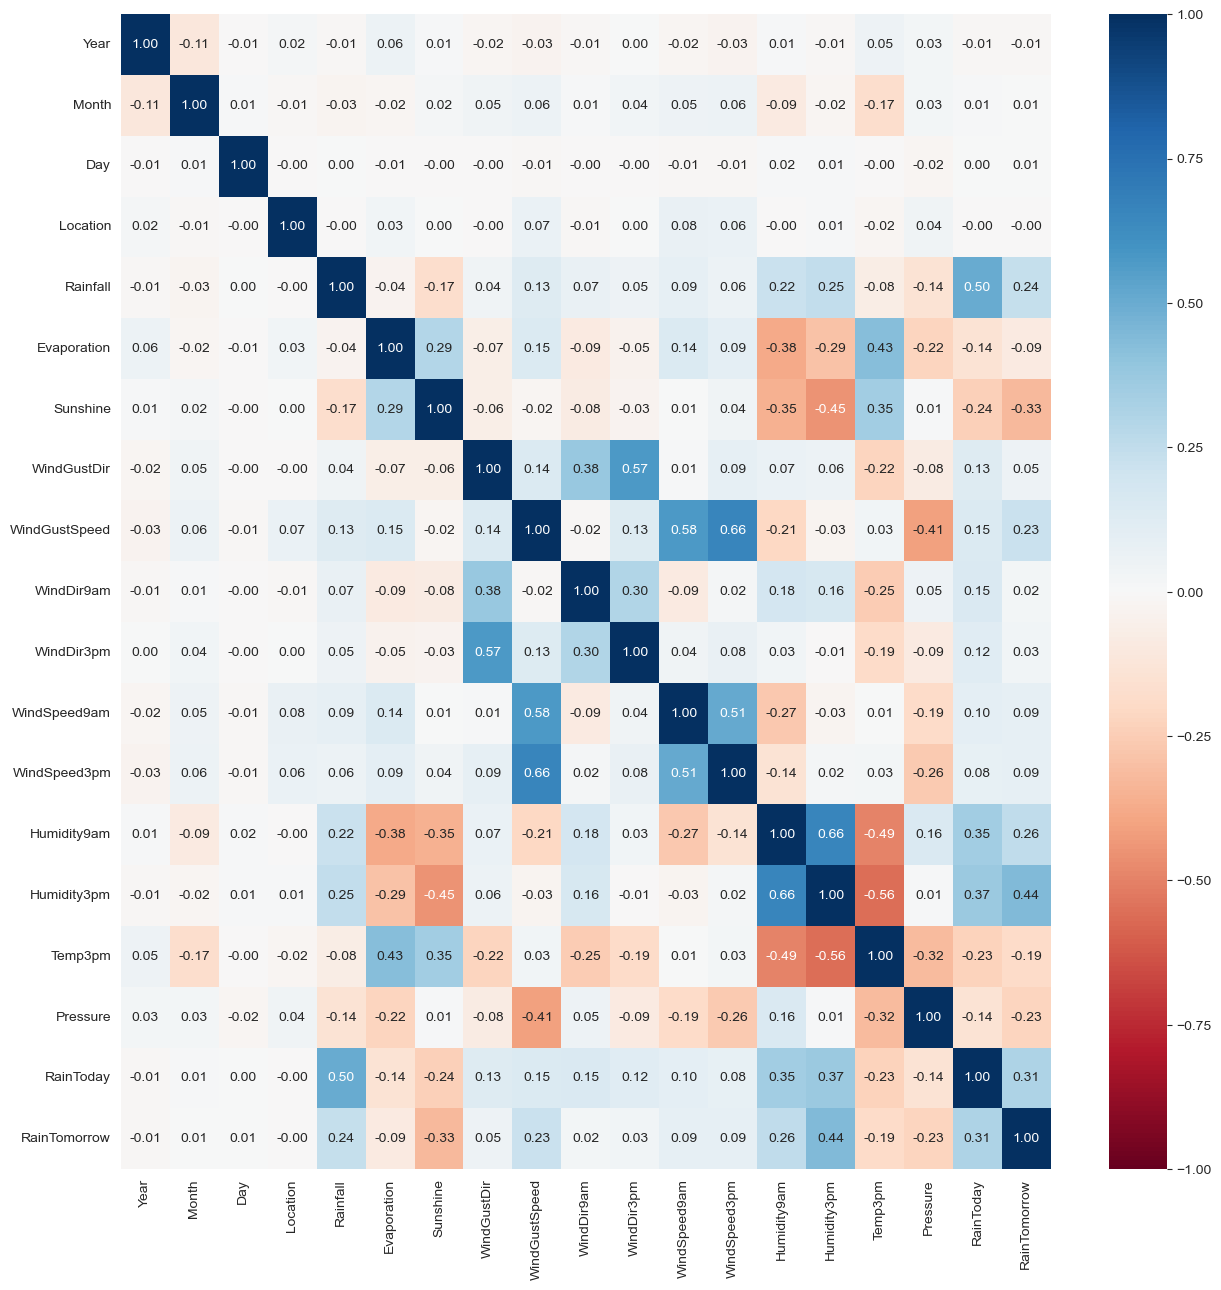

In [21]:
# Тепловая карта корреляционной матрицы
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    data_preprocessed.corr(numeric_only=True),
    annot=True,
    vmin=-1,
    vmax=1,
    ax=ax,
    fmt=".2f",
    cmap="RdBu",
)
plt.show()

### Масштабирование данных

In [22]:
# Масштабирование данных
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_preprocessed.drop(columns=["RainTomorrow"])),
    columns=data_preprocessed.columns[:-1],
)

## Разделение на обучающую и тестовую выборки

In [23]:
X = data_scaled
y = data_preprocessed["RainTomorrow"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)  # test_size и shuffle по условию задачи

## Обучение моделей

Сравнивать качество классификации будем с помощью F1-меры, так как классы несбалансированны.

In [24]:
# Списки моделей и их метрик для последующего сравнения
model_list = ["LogReg", "KNN", "NaiveBayes", "MyLogReg"]
f1_list = []

### Логистическая регрессия

In [25]:
logreg = LogisticRegression(max_iter=1000)

In [26]:
%time logreg.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 44 ms


LogisticRegression(max_iter=1000)

In [27]:
%time y_pred = logreg.predict(X_test)

CPU times: total: 0 ns
Wall time: 1 ms


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     27882
           1       0.74      0.44      0.55      7667

    accuracy                           0.85     35549
   macro avg       0.80      0.70      0.73     35549
weighted avg       0.84      0.85      0.83     35549



In [29]:
f1_list.append(f1_score(y_test, y_pred))

### Метод ближайших соседей

In [30]:
knn = KNeighborsClassifier()

In [31]:
%time knn.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 8 ms


KNeighborsClassifier()

In [32]:
%time y_pred = knn.predict(X_test)

CPU times: total: 10.8 s
Wall time: 2.25 s


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     27882
           1       0.65      0.41      0.50      7667

    accuracy                           0.83     35549
   macro avg       0.75      0.68      0.70     35549
weighted avg       0.81      0.83      0.81     35549



In [34]:
f1_list.append(f1_score(y_test, y_pred))

### Наивный байесовский классификатор

In [35]:
naive_bayes = GaussianNB()

In [36]:
%time naive_bayes.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 27 ms


GaussianNB()

In [37]:
%time y_pred = naive_bayes.predict(X_test)

CPU times: total: 0 ns
Wall time: 10 ms


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     27882
           1       0.63      0.51      0.56      7667

    accuracy                           0.83     35549
   macro avg       0.75      0.71      0.73     35549
weighted avg       0.82      0.83      0.82     35549



In [39]:
f1_list.append(f1_score(y_test, y_pred))

### Логистическая регрессия. Своя реализация

In [40]:
# Данные для тестирования работы функций
theta = np.array([1, 2, 3])

X = np.array([[1, 1, 1], [-1, -2, 1], [-1, -2, 2], [-2, -2, -3]])

y = np.array([1, 1, 0, 0])

In [41]:
def probability(theta: np.ndarray, X: np.ndarray) -> float:
    """
    Вероятность принадлежности классу
    :param theta: Коэффициенты модели
    :param X: Матрица признаков
    :return: Вероятность принадлежности классу
    """
    result = 1 / (1 + np.exp(-np.dot(X, theta)))
    return result

In [42]:
# Тестирование функции probability
prob = probability(theta, X)
assert type(prob) == np.ndarray, "Возвращается неверный тип"
assert prob.shape == (X.shape[0],), "Неверный размер массива"
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.0]).all(), "Функция считается неверно"

In [43]:
def binary_class_prediction(
    theta: np.ndarray, X: np.ndarray, threshold: float = 0.5
) -> int:
    """
    Предсказание модели линейной регрессии
    :param theta: Коэффициенты модели
    :param X: Матрица признаков
    :param threshold: Пороговое значение
    :return: Метки классов, которым принадлежат объекты
    """
    prob = probability(theta, X)
    result = np.where(prob >= threshold, 1, 0)
    return result

In [44]:
# Тестирование функции binary_class_prediction
y_pred = binary_class_prediction(theta, X)
assert type(y_pred) == np.ndarray, "Возвращается неверный тип"
assert y_pred.shape == (X.shape[0],), "Неверный размер массива"
assert min(y_pred) == 0, "Функция считается неверно"
assert max(y_pred) == 1, "Функция считается неверно"

In [45]:
def logloss(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.float64:
    """
    Функция потерь logloss
    :param theta: Коэффициенты модели
    :param X: Матрица признаков
    :param y: Истинные значения меток
    :return: Значение функции потерь
    """
    y_to_ones = np.where(
        y == 0, -1, 1
    )  # Приводим нулевые метки к значению -1 для корректной работы функции
    result = np.mean(np.log(1 + np.exp(-y_to_ones * np.dot(X, theta))))
    return result

In [46]:
# Тестирование функции logloss
assert logloss(theta, X, y).round(3) == 0.861, "Функция считается неверно"

In [47]:
def gradient(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Функция расчёта градиента
    :param theta: Коэффициенты модели
    :param X: Матрица признаков
    :param y: Истинные значения меток
    :return: Значение градиента
    """
    exp = np.exp(-y * np.dot(X, theta))
    result = np.mean(1 / (1 + exp) * exp * -y * X.T, axis=1)
    return result

In [48]:
# Тестирование функции gradient
assert gradient(theta, X, y).shape == theta.shape, "Неверный размер массива"

In [49]:
def fit(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 10,
    h: float = 0.05,
    iters: int = 100,
    plot: bool = True,
) -> np.ndarray:
    """
    Функция обучения модели логистической регрессии
    :param X: Матрица признаков
    :param y: Истинные значения меток
    :param batch_size: Размер батча для стохастического градиентного спуска
    :param h: Шаг обучения
    :param iters: Количество итераций
    :param plot: Нужно ли рисовать графики
    :return: Оптимальные коэффициенты модели
    """

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)

    errors = []

    theta_history = theta
    colors = [plt.get_cmap("gist_rainbow")(i) for i in np.linspace(0, 1, dim)]

    # plt
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle("Gradient descent")

    for _ in range(iters):
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)

        assert type(grad) == np.ndarray, "неверный тип"
        assert len(grad.shape) == 1, "Необходимо вернуть одномерный вектор"
        assert grad.shape[0] == len(
            theta
        ), "длина вектора должна быть равной количеству весов"

        # Обновляем веса

        theta -= grad * h

        theta_history = np.vstack((theta_history, theta))

        # error
        loss = logloss(theta, X, y)
        errors.append(loss)

        if plot:
            ax1.clear()
            ax1.scatter(range(dim), theta, label="Gradient solution")
            ax1.legend(loc="upper left")
            ax1.set_title("theta")
            ax1.set_ylabel(r"$\bar \beta$")
            ax1.set_xlabel("weight ID")

            ax2.plot(range(_ + 1), errors, "g-")
            ax2.set_title("logloss")
            ax2.set_xlabel("itarations")

            ax3.plot(theta_history)
            ax3.set_title("update theta")
            ax3.set_ylabel("value")
            ax3.set_xlabel("itarations")
            time.sleep(0.001)
            fig.canvas.draw()

    return theta

CPU times: total: 4min 6s
Wall time: 21min 47s


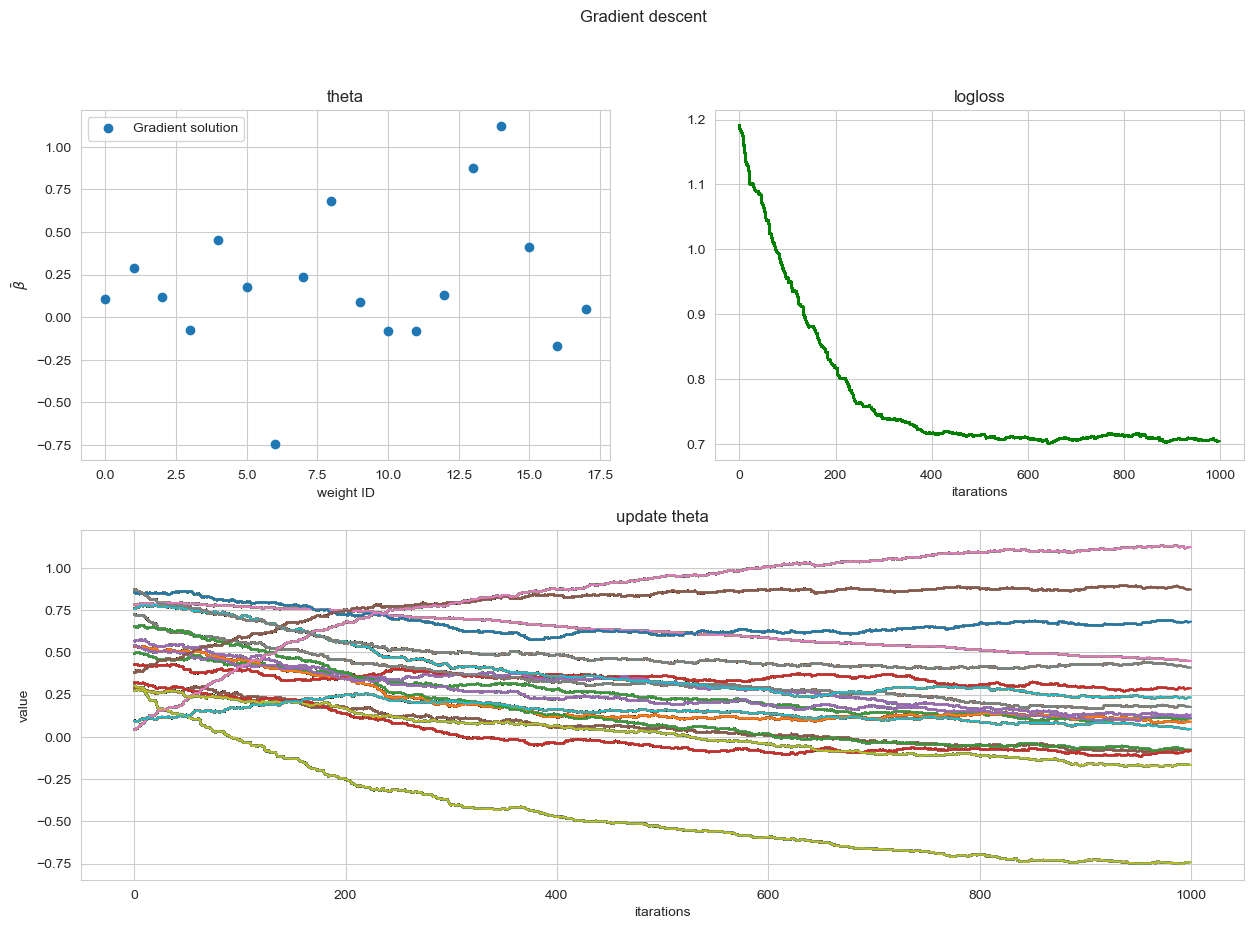

In [50]:
# %matplotlib notebook
%time my_logreg = fit(np.array(X_train), np.array(y_train), iters=1000)

In [51]:
%time y_pred = binary_class_prediction(my_logreg, np.array(X_test))

CPU times: total: 0 ns
Wall time: 2 ms


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.70      0.81     27882
           1       0.44      0.84      0.58      7667

    accuracy                           0.73     35549
   macro avg       0.69      0.77      0.69     35549
weighted avg       0.83      0.73      0.76     35549



In [53]:
f1_list.append(f1_score(y_test, y_pred))

### Сравнение результатов

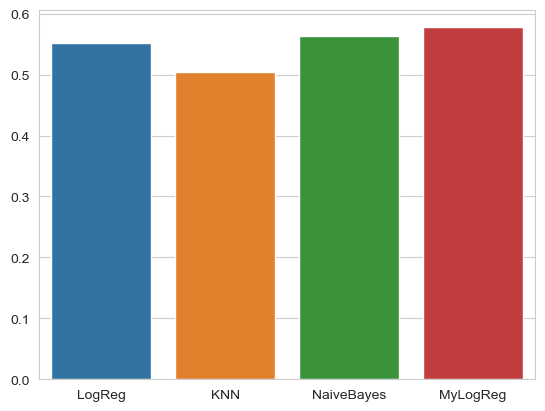

In [54]:
sns.barplot(x=model_list, y=f1_list, hue=model_list)
plt.show()

Лучшим вариантом по качеству оказалась своя реализация логистической регрессии. Однако, она обучается гораздо, гораздо дольше остальных моделей, а также хуже всех определяет нулевой класс.

Также стоит отметить, что все классификаторы лучше определяют нулевой класс.

### Оптимизация гиперпараметров

Попробуем найти гиперпараметры, которые улучшат качество KNN и логистической регресии.

In [65]:
model_optimized_names = [model_list[-1], "KNN\nOptimized", "LogReg\nOptimized"]
f1_optimized_list = [f1_list[-1]]

### Метод ближайших соседей

In [59]:
params = {
    "n_neighbors": np.arange(2, 10),
}

knn_grid = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring="f1")

In [61]:
%time knn_grid.fit(X_train, y_train)

CPU times: total: 3min 28s
Wall time: 45.8 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [62]:
knn_grid.best_params_

{'n_neighbors': 9}

In [68]:
knn_grid.best_score_

0.5158276663452861

In [69]:
knn_best = knn_grid.best_estimator_

y_pred = knn_best.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     27882
           1       0.71      0.39      0.50      7667

    accuracy                           0.83     35549
   macro avg       0.78      0.67      0.70     35549
weighted avg       0.82      0.83      0.81     35549



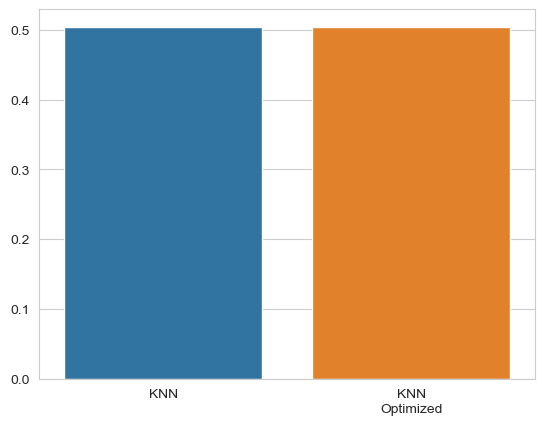

In [71]:
# Сравнение результатов KNN
knn_list = [model_list[1], model_optimized_names[1]]
score_list = [f1_list[1], f1_score(y_test, y_pred)]

sns.barplot(x=knn_list, y=score_list, hue=knn_list)
plt.show()

In [74]:
# F1-мера нового и старого KNN
f1_optimized_list.append(f1_score(y_test, y_pred))
f1_optimized_list[-1], f1_list[1]

(0.5034882743548794, 0.5038436899423446)

### Логистическая регрессия

In [85]:
params = {
    "solver": ["lbfgs", "liblinear"],
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    "tol": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
}

logreg_grid = GridSearchCV(
    LogisticRegression(max_iter=1000), params, cv=5, scoring="f1"
)

In [86]:
%time logreg_grid.fit(X_train, y_train)

CPU times: total: 8.42 s
Wall time: 41.9 s


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'solver': ['lbfgs', 'liblinear'],
                         'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='f1')

In [87]:
logreg_grid.best_params_

{'C': 1, 'solver': 'liblinear', 'tol': 0.0001}

In [88]:
logreg_grid.best_score_

0.5649574655059288

In [89]:
logreg_best = logreg_grid.best_estimator_

y_pred = logreg_best.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     27882
           1       0.74      0.44      0.55      7667

    accuracy                           0.85     35549
   macro avg       0.80      0.70      0.73     35549
weighted avg       0.84      0.85      0.83     35549



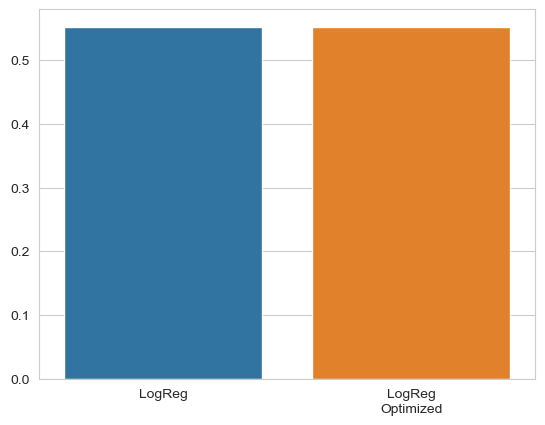

In [90]:
# Сравнение результатов KNN
logreg_list = [model_list[0], model_optimized_names[2]]
score_list = [f1_list[0], f1_score(y_test, y_pred)]

sns.barplot(x=logreg_list, y=score_list, hue=logreg_list)
plt.show()

In [91]:
# F1-мера новой и старой логистической регрессии
f1_optimized_list.append(f1_score(y_test, y_pred))
f1_optimized_list[-1], f1_list[0]

(0.5516335577080939, 0.5512147078135259)

### Вывод по оптимизации

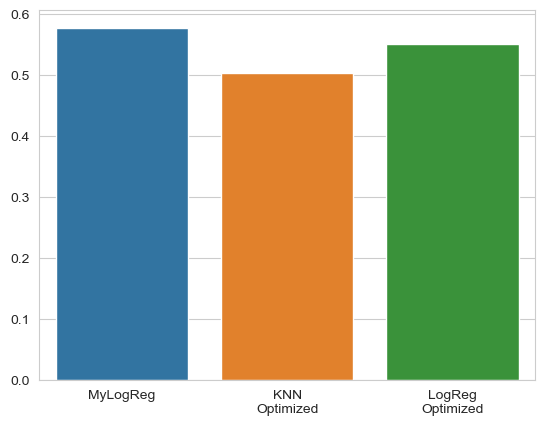

In [92]:
sns.barplot(x=model_optimized_names, y=f1_optimized_list, hue=model_optimized_names)
plt.show()

В результате оптимизации гиперпараметров не удалось улучшить качество классификации, которое побило бы результат нашей регрессии. Также оптимизация гиперпараметров повысило качество исходных моделей на очень малую величину.

## Итоги по работе

В результате выполнения данной работы я сделал следующие выводы:
1. Анализ и предобработка данных важный этап, который нужно проделать перед обучением модели;
2. За "простыми" методами машинного обучения может стоять не очень простая математика;
3. Библиотечные реализации методов машинного обучения, в частности scikit-learn, гораздо удобнее использовать, чем самописные методы, хотя последние могут классифицировать лучше библиотечных при равных условиях. Библиотечные методы машинного обучения также легко интегрируются с другими методами, реализованной в данной библиотеке.